In [17]:
import pandas as pd
import numpy as np
import re

from torch import nn
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import *
import torchvision.models as models


import torch.nn as nn
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from torch.nn import Transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
training_images_path = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images'
training_dataset =pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train.csv')
testing_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test.csv')

training_dataset.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [19]:
# remove stop words 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# remove punctuation
import string
punctuations = string.punctuation

# remove numbers
import re
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# remove extra spaces
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text)
    return text

def word_tokenize(text):
    text = text.split()
    return text

# remove stop words
def remove_stop_words(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

# remove all preprocessing
def remove_all_preprocessing(text):
    text = remove_numbers(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stop_words(text)
    return text

# apply all preprocessing
training_dataset['proc_title'] = training_dataset['title'].apply(lambda x: remove_all_preprocessing(x))
testing_dataset['proc_title'] = testing_dataset['title'].apply(lambda x: remove_all_preprocessing(x))

# get rid of \
training_dataset['proc_title'] = training_dataset['proc_title'].apply(lambda x: x.replace('\\', ''))
testing_dataset['proc_title'] = testing_dataset['proc_title'].apply(lambda x: x.replace('\\', ''))
# lower case
training_dataset['proc_title'] = training_dataset['proc_title'].apply(lambda x: x.lower())
testing_dataset['proc_title'] = testing_dataset['proc_title'].apply(lambda x: x.lower())

training_dataset.head()

,posting_id,image,image_phash,title,label_group,proc_title
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,double tape m vhb mm x original double foam tape
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,maling tts canned pork luncheon meat gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,daster batik lengan pendek motif acak campur l...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,nescafe xcxclair latte ml


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/tmp/ipykernel_770/3597553986.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

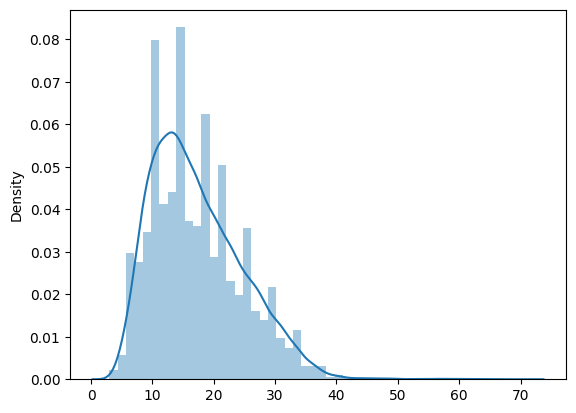

In [20]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#want to determine what number of tokens is best for the model
token_lens = []
for txt in training_dataset.proc_title:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)


In [22]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [23]:
from sentence_transformers.util import cos_sim

titles = training_dataset.proc_title.tolist()
embeddings = model.encode(titles, show_progress_bar=True)

sim = np.zeros((len(titles), len(titles)))

for i in range(len(titles)):
    sim[i:,i] = cos_sim(embeddings[i], embeddings[i:])

sim

Batches: 100%|██████████| 1071/1071 [00:18<00:00, 58.12it/s] 


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16139981, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15478855, 0.22953506, 0.99999994, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04338253, 0.22477441, 0.1686762 , ..., 1.        , 0.        ,
        0.        ],
       [0.04712015, 0.11779243, 0.36419249, ..., 0.1641493 , 0.99999988,
        0.        ],
       [0.1724894 , 0.55592352, 0.2327497 , ..., 0.22983366, 0.15530531,
        1.00000012]])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, training_dataset.label_group, test_size=0.2, random_state=42)

In [34]:
from sklearn.metrics import accuracy_score, f1_score
acc_dict = {}
f1_dict = {}
for k in [1, 2, 3, 5, 10, 25, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Evaluate the performance on the test set
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc_dict[k] = accuracy
    f1_dict[k] = f1

Text(0, 0.5, 'Score')

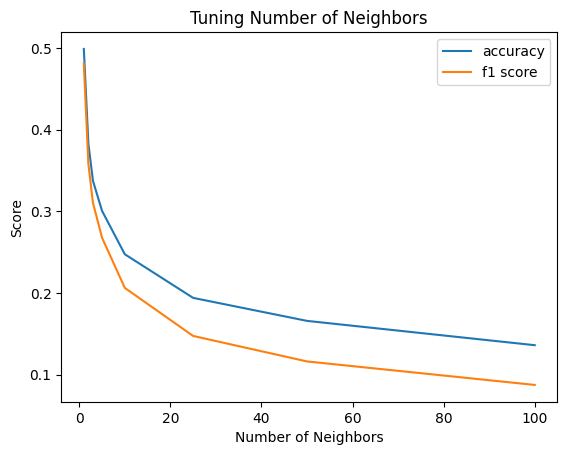

In [39]:
plt.plot(acc_dict.keys(), acc_dict.values(), label='accuracy')
plt.plot(f1_dict.keys(), f1_dict.values(), label='f1 score')
plt.legend()
plt.title('Tuning Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')

In [42]:
print(f'Ideal number of neighbors = {max(acc_dict, key=acc_dict.get)}')
print(f'Accuracy = {acc_dict[max(f1_dict, key=acc_dict.get)]}')
print(f'F1 Score = {f1_dict[max(acc_dict, key=acc_dict.get)]}')

Ideal number of neighbors = 1
Accuracy = 0.498978102189781
F1 Score = 0.4807792604732177


In [44]:
test_titles = testing_dataset.proc_title.tolist()
test_embeddings = model.encode(test_titles, show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 120.54it/s]


In [45]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(test_embeddings)
y_true = testing_dataset.label_group.tolist()
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy = {accuracy}')
print(f'F1 score = {f1}')

AttributeError: 'DataFrame' object has no attribute 'label_group'

,posting_id,image,image_phash,title,proc_title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,edufuntoys character phone ada lampu dan musik...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,beli free spatula masker komedo blackheads mas...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,ready lemonilo mie instant sehat kuah dan goreng
